In [182]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [248]:
n_epochs = 2   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50     # Size of the train dataset
n_test = 1      # Size of the test dataset

SAVE_PATH = "./quanvolution/" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [249]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = tf.convert_to_tensor(train_labels[:n_train])
test_images = test_images[:n_test]
test_labels = tf.convert_to_tensor(test_labels[:n_test])

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = tf.convert_to_tensor(train_images[..., tf.newaxis])
test_images = tf.convert_to_tensor(test_images[..., tf.newaxis])

In [ ]:
    
    def quanv(image, params, filters = 1):
        
        out = tf.zeros((14, 14, filters))
        # Loop over the coordinates of the top-left pixel of 2X2 squares
        I = []
        for i in range(filters):
            J = []
            for j in range(0, 28, 2):
                K = []
                for k in range(0, 28, 2):
                    # Process a squared 2x2 region of the image with a quantum circuit
                    
                    q_results = scalar_prod(
                        tf.convert_to_tensor([
                            image[j, k, 0],
                            image[j, k + 1, 0],
                            image[j + 1, k, 0],
                            image[j + 1, k + 1, 0]
                        ]), params[i]
                    )
                    # Assign expectation values to different channels of the output pixel (j/2, k/2)
                    K.append(q_results)
                J.append(K)
            I.append(J)
        return tf.convert_to_tensor(I)
    
    def scalar_prod(phi, params):

        prob = circuit(phi,params)[0]
        return prob

    @qml.qnode(dev, interface = "tf")
    def circuit(phi, params):

        # Encoding of 4 classical input values
        for j in range(4):
            qml.RY(np.pi * phi[j], wires=j)

        for layer in range(params.shape[0]):
            for i in range(params.shape[1]):
                qml.RY(np.pi * params[layer,i], wires=i)

        # Measurement producing 4 classical output values
        return qml.probs(wires = range(4))
    
                    #filtros #layer #wires
        

    filters = 1
    layers = 1
    wires = 4
    out_h1 = 10
    params = tf.Variable(tf.cast(tf.random.normal([filters,layers, wires]), dtype = tf.float64))
    W = tf.Variable(tf.cast(tf.random.normal((14 * 14 * filters, out_h1)), dtype = tf.float64))
    b = tf.Variable(tf.cast(tf.random.normal((out_h1,)), dtype = tf.float64))
    
    def x_hidden(x,W,b):
        x = tf.cast(x, dtype = tf.float64)
        
        
        return tf.nn.softmax(x @ W + b)
    
    def to_vector(n):
        L = [0] * 10
        L[n] = 1
        return tf.cast(tf.convert_to_tensor(L), dtype = tf.float64)

    losses = []
    for i in range(n_epochs):
        for j in range(n_train):
            with tf.GradientTape() as tape:
                image = tf.reshape(quanv(train_images[j], params, filters),[1,-1])
                #print((x_hidden(image,W,b)- to_vector(train_labels[j])))
                loss = sum(((x_hidden(image,W,b)- to_vector(train_labels[j])) ** 2)[0])
                # comprobar como esta definido el error, creo que algo falla
                losses.append(loss)
                print(loss)
            gradients = tape.gradient(loss, [params,W,b])
            
            
            lr_c = 0.05
            lr_q = 0.3
            params = tf.Variable(params - lr_q * gradients[0])
            W = tf.Variable(W - lr_c * gradients[1])
            b = tf.Variable(b - lr_c * gradients[2])
            #plt.imshow(quanv(train_images[j], params, filters)[0])
            #plt.show()

# por lo menos parece que se entrena, habría que meterlo en la red y cambiar esta función de error

tf.Tensor(1.5517615295687008, shape=(), dtype=float64)
tf.Tensor(1.380647737038326, shape=(), dtype=float64)
tf.Tensor(0.7374721988543604, shape=(), dtype=float64)


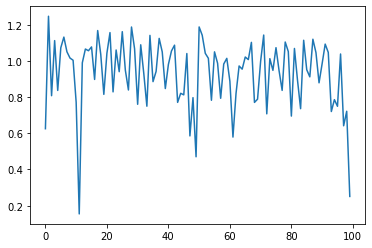

In [255]:
plt.plot(losses)